# Data Science Bootcamp Group 2 Project 1
# Medicare In-Patient Data Analysis: What is Ailing the Elderly?
### By: Brian Connel, Jeff Rosal, Ashok Bidani, and Michael Stewart

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from states import us_state_abbrev
from scipy import stats as stat
from over65 import over65

## We obtained our data from data.cms.gov (https://data.cms.gov/browse?category=Medicare%20-%20Inpatient)
### We chose this data source since they are pre-cleaned reports from government agencies (that likely use them internally). We specifically focused on in-patient discharge information due to the large amount of data in each table and that the data were available longitudinally (2011-2015)
### We speculated that we could look at three major types of data:
#### 1) What types of illnesses predominate among Medicare discharges?
#### 2) What is the scale and variability of Medicare payments by state?
#### 3) How have these changed over time?

In [2]:
# Declare filepaths to our CSV files
csv_path_2011 = "../data/Medicare_Provider_Charge_Inpatient_DRG100_FY2011.csv"
csv_path_2012 = "../data/Medicare_Provider_Charge_Inpatient_DRG100_FY2012.csv"
csv_path_2013 = "../data/Medicare_Provider_Charge_Inpatient_DRG100_FY2013.csv"
csv_path_2014 = "../data/Medicare_Provider_Charge_Inpatient_DRGALL_FY2014.csv"
csv_path_2015 = "../data/Medicare_Provider_Charge_Inpatient_DRGALL_FY2015.csv"
population_path = "../data/NST-EST2017-01.csv"
geojson_path = '../data/us_states_geo.json'


# Read our data into pandas
df_2011 = pd.read_csv(csv_path_2011)
df_2011['year'] = '2011'
df_2012 = pd.read_csv(csv_path_2012)
df_2012['year'] = '2012'
df_2013 = pd.read_csv(csv_path_2013)
df_2013['year'] = '2013'
df_2014 = pd.read_csv(csv_path_2014)
df_2014['year'] = '2014'
df_2015 = pd.read_csv(csv_path_2015)
df_2015['year'] = '2015'

df = pd.concat([df_2011,df_2012,df_2013,df_2014,df_2015])

## We realized early on that while there was an abundance of state-by-state data, none of it was normalized and that would impact statistical analysis.
### To remedy this, Brian found a CSV of populations by year that also included regional information. By loading this into a dataframe, we could pull the population values into our main dataframe and normalize discharges by population

In [3]:
# Read the population data into a pandas dataframe
df_pop = pd.read_csv(population_path)

## We also realized early on that the DRG, Medicare's 'grouped diagnosis' term, is both a blessing a curse.
### DRG's simplify noise in the data by grouping codes with similar diagnoses together. However, there exists a plethora of DRG's that are similar for our purposes, but distinct due to things like complications or comorbidities.
### To remedy this, Brian deployed RegEx to search through the dataframe of DRG's and replace the patterns with emptry strings:

In [4]:
# just to show original DRGs
drg_titles = set(df['DRG Definition'].unique())
# print(len(drg_titles),drg_titles)

In [5]:
#cleaning DRG titles to create 'mod_DRG Definition' series
patterns= [' W/O CC/MCC',' W/O MCC',' W MCC', ' W CC', ' MCC', '/MCC']
df['step1_mod_DRG Definition'] = df['DRG Definition'].replace(patterns, "", regex=True)
# knock off 'xxx - ', always 3 digits + ' - '
df['mod_DRG Definition'] = df['step1_mod_DRG Definition'].apply(lambda x : x[6:])
df.drop(columns=['step1_mod_DRG Definition'],inplace=True)

##### This for loop takes a minute, test code outside to minimize waiting or consider saving as csv

In [6]:
# Rename the USPS & Provider State columns to state for simplification of labels
df = df.rename(columns={'Provider State':'state'})
df_pop = df_pop.rename(columns={'USPS':'state'})
# Reindex df_pop by state for using loc to look up values later
df_pop = df_pop.set_index('state')
# Re-index to add blank column
list_of_columns = [column for column in df.columns.values]
list_of_columns.append('population')
#list_of_columns.append('division')
#list_of_columns.append('region')
df = df.reindex(columns=list_of_columns)
# Create an empty list that will be filled with the state/year population from df_pop
# the list will then be used to fill the empty pandas column 'population'
list_of_pops = []
list_of_divisions = []
list_of_regions = []
list_of_over65 = []
for index,row in df.iterrows():
    _state_year_population = df_pop.loc[row['state'],row['year']]
    #_state_division = df_pop.loc[row['state'],['Division']]
    #_state_region = df_pop.loc[row['state'],['Region']]
    _state_year_population = _state_year_population.replace(',','')
    list_of_pops.append(_state_year_population)
    #list_of_divisions.append(_state_division)
    #list_of_regions.append(_state_region)
    #print(f"Row#{index},{row['state']},{row['year']}:",_state_year_population)
df['population']=list_of_pops
#df['division']=list_of_divisions
#df['region']=list_of_regions
print("I'm done!")

I'm done!


##### End slow codeblock -- Execute below codeblock to save CSV

In [ ]:
# Save working df to csv option:
#df.to_csv('df_working.csv',sep=',')

#df = pd.read_csv('df_working.csv')
#df.head()

## Create relative columns in main dataframe for downstream analysis

In [7]:
# Create an empty column for "1e5s of pop" and "relative discharges"
list_of_columns = [column for column in df.columns.values]
list_of_columns.append('1e5s of pop')
list_of_columns.append('relative discharges')
list_of_columns.append('medicare payments per capita')
#df = df.reindex(columns=list_of_columns)
# Create a list of relative (100,000s) populations and add to dataframe
list_of_rel_pops = []
for pop in list_of_pops:
    pop = int(pop) / 100000
    list_of_rel_pops.append(pop)

df['1e5s of pop'] = list_of_rel_pops
# Do the same to create a list of relative discharges
list_of_rel_discharges =[]
for discharges, relpop in zip(df['Total Discharges'],df['1e5s of pop']):
    rel_disch = discharges / float(relpop)
    list_of_rel_discharges.append(rel_disch)
df['relative discharges'] = list_of_rel_discharges

# Do the same to create a list of per capita spending
list_of_rel_payments =[]
for payments, pops in zip(df['Average Medicare Payments'],df['1e5s of pop']):
    rel_payments = payments / float(pops)
    list_of_rel_payments.append(rel_payments)
df['medicare payments per 1e5 pop'] = list_of_rel_payments

## We wanted to begin by analyzing nationwide trends in discharges and payments to get an idea of any large-scale changes.

In [8]:
# Groupby year in the df to sum
yeargroup = df.groupby('year')
revised_yeargroup = yeargroup.sum()
reduced_yeargroup = revised_yeargroup.loc[:, ["Total Discharges",'Average Medicare Payments']]
reduced_yeargroup.head()

,Total Discharges,Average Medicare Payments
year,,
2011,6975318,1.385155e+09
2012,6662965,1.376933e+09
2013,6517112,1.359168e+09
2014,7297885,2.273489e+09
2015,7433268,2.263819e+09


[-0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5]


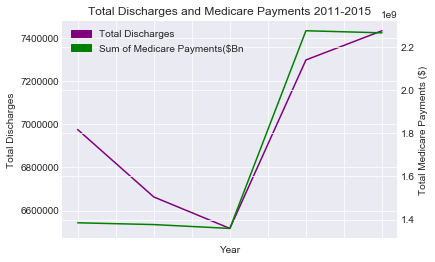

In [9]:
# Create axis object that contains the sum of all discharges each year over 2011-2015
sns.set_style('darkgrid')
fig, early_discharges = plt.subplots()
early_discharges = reduced_yeargroup['Total Discharges'].plot(kind='line',color='purple')
ax1 = early_discharges
ax1.set_xlabel("Year")
#Produce second axis object that shares the x axis with ax1
ax2 = ax1.twinx()
ax2 = reduced_yeargroup['Average Medicare Payments'].plot(kind='line',color='green')
#Title chart and axes
tot_disch = mpatches.Patch(color='purple', label='Total Discharges')
sum_pay = mpatches.Patch(color='green', label='Sum of Medicare Payments($Bn')
plt.legend(handles=[tot_disch,sum_pay])
ax1.set_ylabel('Total Discharges')
ax2.set_ylabel('Total Medicare Payments ($)')
ax1.set_title('Total Discharges and Medicare Payments 2011-2015')
print(ax1.get_xticks())
plt.show()

## It's notable there is a relatively large inflection beginning in 2013-2014.
### By reading the documentation, we found out that earlier datasets 2011-2013 contained only the top 100 DRG's (though ranking schema was not disclosed). After 2014, data would be available for all DRG's. This is why the number of discharges trend so closely.

# ***Note Brian Wanted Regional Charts Here
## When we plotted the total of discharges by state we initially saw several large outliers, which could be explained by their large state populations having a larger number of elderly people.

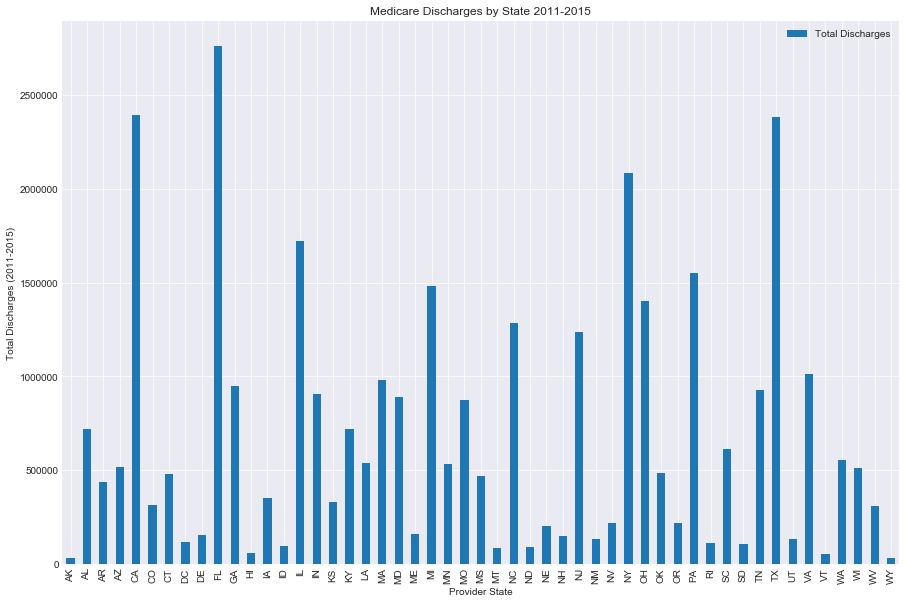

In [10]:
stategroup = df.groupby('state')
revised_stategroup = stategroup.sum()
reduced_stategroup = revised_stategroup.loc[:, ["Total Discharges"]]
state_discharges = reduced_stategroup.plot(kind='bar',figsize=(15,10))
state_discharges.set_xlabel("Provider State")
state_discharges.set_ylabel("Total Discharges (2011-2015)")
state_discharges.set_title('Medicare Discharges by State 2011-2015')
plt.show()

## We then chose to normalize by discharges per 100,000 people and see what variance remained

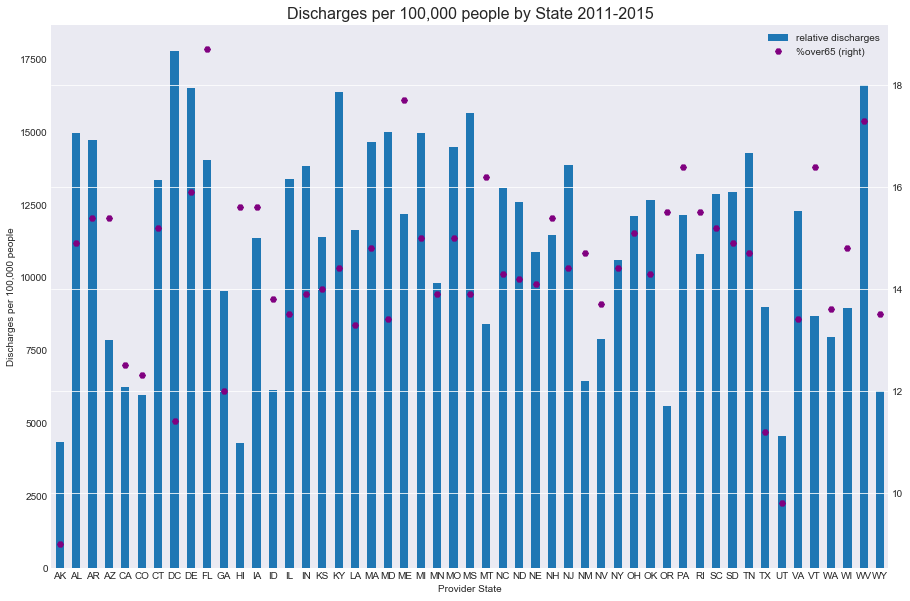

In [11]:
# To create a population normalized graph, begin by grouping by state
stategroup = df.groupby('state')
revised_stategroup = stategroup.sum()
reduced_stategroup_rel = revised_stategroup.loc[:, ["relative discharges"]]
# Create an empty column for "1e5s of pop" and "relative discharges"
list_of_columns = [column for column in reduced_stategroup_rel.columns.values]
list_of_columns.append('%over65')
reduced_stategroup_rel = reduced_stategroup_rel.reindex(columns=list_of_columns)
list_of_over65 = []
for state in reduced_stategroup_rel.index.values:
    list_of_over65.append(over65[state])
reduced_stategroup_rel['%over65'] = list_of_over65
plotting_df = reduced_stategroup_rel
plotting_df_over65 = pd.DataFrame(index=plotting_df.index.values,data=plotting_df['%over65'],columns=['%over65'],dtype='float64')
ax1 = plotting_df.plot(x=plotting_df.index.values,kind='bar',figsize=(15,10))
ax2 = plotting_df_over65.plot(secondary_y=True,ax=ax1,sharex=True,sharey=False,label='% Over 65',kind='line',style='H',color='purple')
ax1.set_xlabel("Provider State")
ax1.set_ylabel("Discharges per 100,000 people")
ax1.set_title(label='Discharges per 100,000 people by State 2011-2015',fontsize=16)
plt.show()

## Thus, we saw that even with population-normalized values, there is variance of discharges that cannot be explained by simply the the percent of the population that is >65
## We then wanted to investigate whether similar trends occurred in Medicare spending by state:

Text(0,0.5,'Discharges per 100,000')

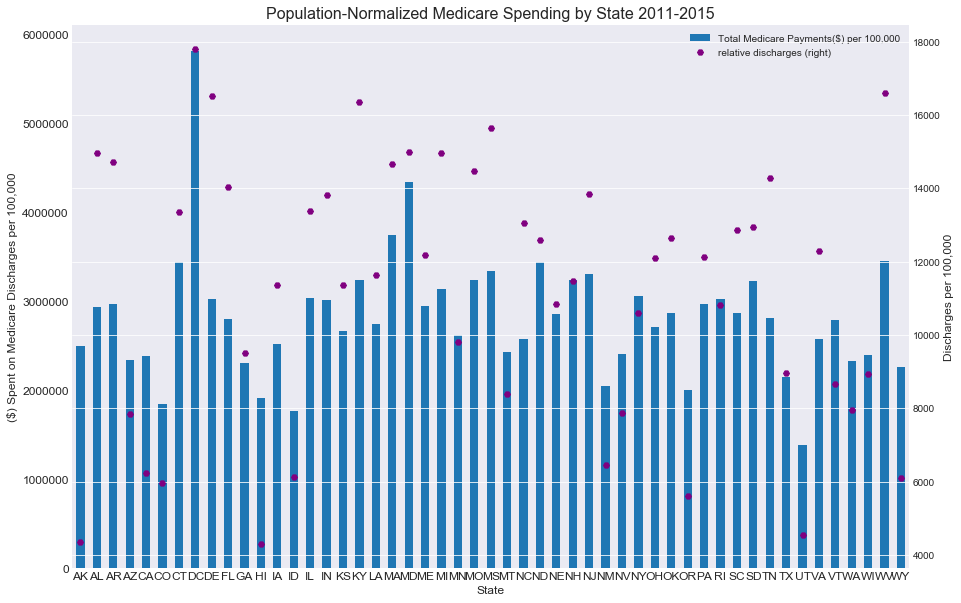

In [12]:
# Construct a dataframe to hold the sum of medicare payments grouped by states
totalmedicarebystate = df.groupby('state')['medicare payments per 1e5 pop'].sum()
totalmedicarebystate = pd.DataFrame(data=totalmedicarebystate,dtype=np.float64)
totalmedicarebystate = totalmedicarebystate.rename(columns={'medicare payments per 1e5 pop':'Total Medicare Payments($) per 100,000'})
# Plot the relative expenses along with relative discharges
ax1 = totalmedicarebystate.plot(kind='bar',figsize=(15,10), fontsize=12)
ax2 = plotting_df.plot(secondary_y=True,ax=ax1,sharex=True,sharey=False,label='Relative Discharges',kind='line',style='H',color='purple')
ax1.set_title(label ='Population-Normalized Medicare Spending by State 2011-2015',fontsize=16)
ax1.set_xlabel('State',fontsize=12)
ax1.set_ylabel('($) Spent on Medicare Discharges per 100,000',fontsize=12)
ax2.set_ylabel('Discharges per 100,000', fontsize=12)

## This relationship can also be represented as a scatter plot between the two relative metrics

{'slope': 150.6399, 'intercept': 1131123.094, 'r-value': 0.7838, 'p-value': 0.0, 'stderr': 17.0514, 'r^2': 0.6143}


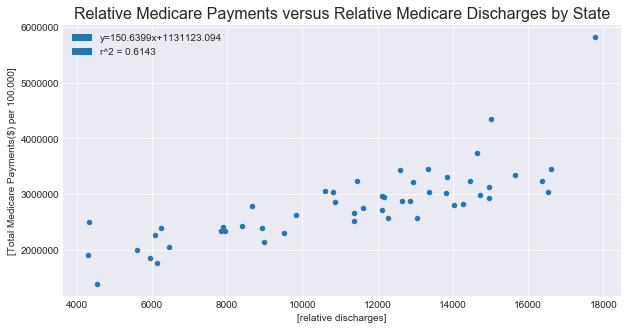

In [13]:
# Create a dataframe of the two data series plotted abo e
comb_rel_spending_df = pd.DataFrame(data={'relative discharges':plotting_df['relative discharges'],
                                         'Total Medicare Payments($) per 100,000':totalmedicarebystate['Total Medicare Payments($) per 100,000']})
# Plot this dataframe and perform regression analysis with SciPy.stats
comb_ax = comb_rel_spending_df.plot(x=['relative discharges'],y=['Total Medicare Payments($) per 100,000'],
                                    kind='scatter',
                                    figsize=(10,5))
comb_ax.set_title(label='Relative Medicare Payments versus Relative Medicare Discharges by State',fontsize=16)
regression = stat.linregress(x=comb_rel_spending_df['relative discharges'],
                             y=comb_rel_spending_df['Total Medicare Payments($) per 100,000'])
# Load regression values into a dictionary for quick-calling
reg_list = [*regression]
regres_dict = {'slope':'','intercept':'','r-value':'','p-value':'','stderr':''}
for stat_val,stat_key in zip(reg_list,regres_dict):
    regres_dict[stat_key] = round(stat_val,4)
# Generate an r^2 value
r_sq = round(regres_dict['r-value']**2,4)
regres_dict['r^2']= r_sq
print(regres_dict)
# Generate pyplot patches to load into the legend
regres_equation = mpatches.Patch(color=None, label=(f"y={regres_dict['slope']}x+{regres_dict['intercept']}"))
r_sq_patch = mpatches.Patch(color=None, label=(f"r^2 = {regres_dict['r^2']}"))
plt.legend(handles=[regres_equation,r_sq_patch])

## As above, this shows us that the relation between relative price and relative discharges is approximately linear and has a non-zero slope. The presence of outliers likely diminishes the linearity of this.

## We also wanted to know that state-by-state, what is the most common disease that afflicts the elderly? To accomplish this, we grouped by DRG's and state and then sum'd the population-adjusted discharges.

In [14]:
# Group on state and mod_DRG Definition and sum the rel discharges
diagnosesgroup = df.groupby(['state','mod_DRG Definition'])
newdiagnoses = diagnosesgroup['relative discharges'].sum()
# Sort the GroupBySeries
newdiagnoses.sort_values(inplace = True, ascending=[False])
# Create empty dicts to hold the drg and counts for constructing a dataframe
countsdictionary = {}
drgdictionary = {}
for state,drg in newdiagnoses.index.values:
    drgdictionary[state] = drg
    countsdictionary[state] = newdiagnoses[state].iloc[0], newdiagnoses[state].index.values[0]
# Construct DataFrame from the dictionary and rename columns
state_drg_counts = pd.DataFrame.from_dict(countsdictionary,orient='index')
state_drg_counts = state_drg_counts.rename(columns={0:'relative discharges',1:'mod_DRG Definition'})

In [15]:
state_drg_counts['mod_DRG Definition'].value_counts()

MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY    19
SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS                  15
HEART FAILURE & SHOCK                                         14
CHRONIC OBSTRUCTIVE PULMONARY DISEASE                          2
SIMPLE PNEUMONIA & PLEURISY                                    1
Name: mod_DRG Definition, dtype: int64

## To try and visualize the data differently, we thought a geoheatmap could be informative for allowing people to see the data projected on a map of the US
### To achieve this, we looked to GeoPandas, a library that allows the mapping of geoJSON's into pandas dataframes

In [16]:
##Read GeoJSON data into geopandas dataframe
usa = gpd.read_file(geojson_path)
# Read total medicare discharges by state into a dataframe
medbystatedf = totalmedicarebystate
# Iterate over rows in geoDF to replace state name's with abbrev's
# this will make the dataframe compatible with the Medicare data
for row, index in usa.iterrows():
    #Drop Puerto Rico from the geodataframe as we have no medicare data for it
    if index['NAME'] == 'Puerto Rico':
        usa.drop(labels=row,axis=0,inplace=True)
    else:
        usa.replace(to_replace=index['NAME'],value=us_state_abbrev[index['NAME']],inplace=True)
medbystatedf.head()

,"Total Medicare Payments($) per 100,000"
state,
AK,2.500350e+06
AL,2.937068e+06
AR,2.976513e+06
AZ,2.342166e+06
CA,2.388380e+06


In [17]:
# Merge geoDF and medicareDF on the State Name column
usa['NAME'] = usa['NAME'].astype(str)
medbystatedf['state'] = ''
list_of_states = []
for row, index in medbystatedf.iterrows():
    list_of_states.append(str(row))
medbystatedf['state'] = list_of_states
medbystate_wgeo_df = usa.merge(right=medbystatedf,how='outer',left_on='NAME',right_on='state')
medbystate_wgeo_df.drop(columns=['GEO_ID','STATE','LSAD','CENSUSAREA'],inplace=True)

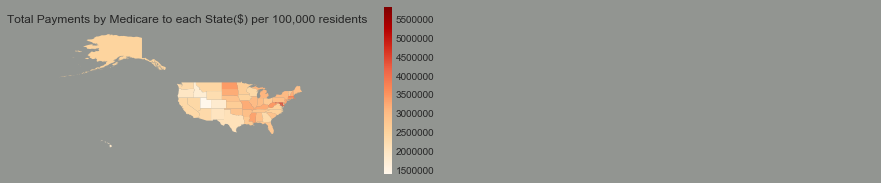

In [18]:
#Create plot of GeoMap data and format axes to be tight around US map
ax = medbystate_wgeo_df.plot(cmap='OrRd',column='Total Medicare Payments($) per 100,000')
ax.set_xlim(xmax=-60,xmin=-180)
#Add in continuous color bar
from matplotlib.colors import Normalize
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
norm = Normalize(vmin=medbystate_wgeo_df['Total Medicare Payments($) per 100,000'].min(), 
                 vmax=medbystate_wgeo_df['Total Medicare Payments($) per 100,000'].max())
n_cmap = cm.ScalarMappable(norm=norm, cmap='OrRd')
n_cmap.set_array([])
ax.get_figure().colorbar(n_cmap,fraction=0.025, pad=0.2)
ax.set_title('Total Payments by Medicare to each State($) per 100,000 residents')
ax.set_axis_off()
ax.get_figure().set_facecolor('xkcd:grey')
plt.savefig('rel_medicare_payments_geo',dpi=1000)
plt.show()

## As seen on the GeoHeatMap, an immediate trend is that several states with low populations actually end up having the most Medicare spent on them, relative to their populations and DC and Maryland continue to show as outliers

In [19]:
# Merge geoDF and medicareDF on the Name column
state_drg_counts['state'] = ''
list_of_states = []
for row, index in state_drg_counts.iterrows():
    list_of_states.append(row)
state_drg_counts['state'] = list_of_states
geo_state_drg = state_drg_counts.merge(right=usa,how='outer',left_on='state',right_on='NAME')
geo_state_drg.drop(columns=['GEO_ID','STATE','LSAD','CENSUSAREA'],inplace=True)
# Create a column that holds numerical values for each DRG
# this will allow colormapping on the geoheatmap
geo_state_drg['drg_num'] = 0
list_of_drg_nums = []
for row, index in state_drg_counts.iterrows():
    if index['mod_DRG Definition'] == 'MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY':
        list_of_drg_nums.append(10)
    elif index['mod_DRG Definition'] == 'SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS':
        list_of_drg_nums.append(20)
    elif index['mod_DRG Definition'] == 'HEART FAILURE & SHOCK':
        list_of_drg_nums.append(30)
    elif index['mod_DRG Definition'] == 'CHRONIC OBSTRUCTIVE PULMONARY DISEASE':
        list_of_drg_nums.append(40)
    elif index['mod_DRG Definition'] == 'SIMPLE PNEUMONIA & PLEURISY':
        list_of_drg_nums.append(50)
    else:
        print(f"Something went wrong on {index}")
geo_state_drg['drg_num'] = list_of_drg_nums
geo_state_drg = geo_state_drg.set_index(keys=['NAME'],drop=True)
# Remake the merged dataframe as a geodataframe
geo_state_drg = gpd.GeoDataFrame(geo_state_drg)

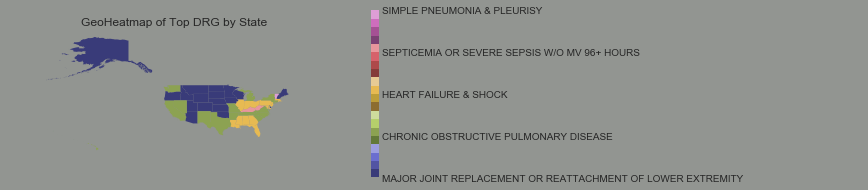

In [20]:
#Create plot of GeoMap data and format axes to be tight around US map
list_of_drgs = []
for drg in geo_state_drg['mod_DRG Definition'].unique():
    list_of_drgs.append(drg)
    list_of_drgs.append('')
ax = geo_state_drg.plot(cmap='tab20b',column='drg_num')
norm = Normalize(vmin=geo_state_drg['drg_num'].min(), 
                 vmax=geo_state_drg['drg_num'].max())
n_cmap = cm.ScalarMappable(norm=norm, cmap='tab20b')
n_cmap.set_array([])
cb = ax.get_figure().colorbar(n_cmap,fraction=0.025, pad=0.2)
cb.ax.set_yticklabels(list_of_drgs)
ax.set_xlim(xmax=-60,xmin=-180)
ax.set_title('GeoHeatmap of Top DRG by State')
ax.set_axis_off()
ax.get_figure().set_facecolor('xkcd:grey')
plt.savefig('Output',dpi=1000)
plt.show()

## Interestingly, there appears to be clusters of states with top DRG's that is both regional and related to overall population. Rural states appear to have their top DRG as joint replacements.
### While there is not an immediate explanation for pneumonia in Vermont, Kentucky and WV being the only states with COPD as their top DRG seems validating due to the prevalence of the mining industry in those states for people >65
## We finally wanted to see how the DRG's are changing over time to see if there are any worrisome trends for Medicare users

In [21]:
septicemia = df.loc[df['mod_DRG Definition'] == 'SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS']
heart_failure_shock = df.loc[df['mod_DRG Definition'] == 'HEART FAILURE & SHOCK']
major_joint_replacement = df.loc[df['mod_DRG Definition'] == 'MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY']
simple_pneumonia_pleurisy = df.loc[df['mod_DRG Definition'] == 'SIMPLE PNEUMONIA & PLEURISY']
pulmonary_disease = df.loc[df['mod_DRG Definition'] == 'CHRONIC OBSTRUCTIVE PULMONARY DISEASE']
yearly_septicemia = septicemia.groupby('year')
revised_yearly_septicemia = yearly_septicemia.sum()
reduced_yearly_septicemia = revised_yearly_septicemia.loc[:, ["Total Discharges"]]
reduced_yearly_septicemia = reduced_yearly_septicemia.rename(columns = {"Total Discharges": "Total Septicemia Discharges"})
yearly_heart_failure_shock = heart_failure_shock.groupby('year')
revised_yearly_heart_failure_shock = yearly_heart_failure_shock.sum()
reduced_yearly_heart_failure_shock = revised_yearly_heart_failure_shock.loc[:, ["Total Discharges"]]
reduced_yearly_heart_failure_shock = reduced_yearly_heart_failure_shock.rename(columns = {"Total Discharges": "Total Heart Failure & Shock Discharges"})
yearly_major_joint_replacement = major_joint_replacement.groupby('year')
revised_yearly_major_joint_replacement = yearly_major_joint_replacement.sum()
reduced_yearly_major_joint_replacement = revised_yearly_major_joint_replacement.loc[:, ["Total Discharges"]]
reduced_yearly_major_joint_replacement = reduced_yearly_major_joint_replacement.rename(columns = {"Total Discharges": "Total Major Joint Replacement Discharges"})
yearly_simple_pneumonia_pleurisy = simple_pneumonia_pleurisy.groupby('year')
revised_yearly_simple_pneumonia_pleurisy = yearly_simple_pneumonia_pleurisy.sum()
reduced_yearly_simple_pneumonia_pleurisy = revised_yearly_simple_pneumonia_pleurisy.loc[:, ["Total Discharges"]]
reduced_yearly_simple_pneumonia_pleurisy = reduced_yearly_simple_pneumonia_pleurisy.rename(columns = {"Total Discharges": "Total Simple Pneumonia & Pleurisy Discharges"})
yearly_pulmonary_disease = pulmonary_disease.groupby('year')
revised_yearly_pulmonary_disease = yearly_pulmonary_disease.sum()
reduced_yearly_pulmonary_disease = revised_yearly_pulmonary_disease.loc[:, ["Total Discharges"]]
reduced_yearly_pulmonary_disease = reduced_yearly_pulmonary_disease.rename(columns = {"Total Discharges": "Total Pulmonary Disease Discharges"})

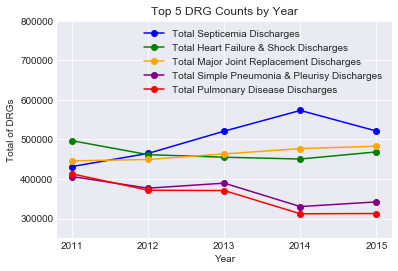

In [33]:
plt.plot(reduced_yearly_septicemia.index.values, reduced_yearly_septicemia['Total Septicemia Discharges'], marker = 'o', color = 'blue')
plt.plot(reduced_yearly_heart_failure_shock.index.values, reduced_yearly_heart_failure_shock['Total Heart Failure & Shock Discharges'], marker = 'o', color = 'green')
plt.plot(reduced_yearly_major_joint_replacement.index.values, reduced_yearly_major_joint_replacement['Total Major Joint Replacement Discharges'], marker = 'o', color = 'orange')
plt.plot(reduced_yearly_simple_pneumonia_pleurisy.index.values, reduced_yearly_simple_pneumonia_pleurisy['Total Simple Pneumonia & Pleurisy Discharges'], marker = 'o', color = 'purple')
plt.plot(reduced_yearly_pulmonary_disease.index.values, reduced_yearly_pulmonary_disease['Total Pulmonary Disease Discharges'], marker = 'o', color = 'red')

plt.xticks(reduced_yearly_septicemia.index.values)
plt.ylim(bottom = 250000, top = 800000)
_ax = plt.gca()
_ax.set_title('Top 5 DRG Counts by Year')
_ax.set_xlabel('Year')
_ax.set_ylabel('Total of DRGs')
plt.legend()
plt.show()